<a href="https://colab.research.google.com/github/gabilodeau/INF6804/blob/master/OpenPose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INF6804 Vision par ordinateur

Polytechnique Montréal

Author: Soufiane Lamghari


Description : This notebook implements the OpenPose model for human pose estimation in inference.

Import libraries

In [1]:
from PIL import Image
from skimage import io
import os
import matplotlib.pyplot as plt
import sys
import cv2
from sys import platform
import argparse
from google.colab.patches import cv2_imshow
from os.path import exists, join, basename, splitext
from base64 import b64encode
from IPython.display import HTML

Clone github repo, install dependecies and build the model

In [2]:
git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'

!wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
!tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

!git clone -q --depth 1 $git_repo_url
!sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt

!apt-get > /dev/null install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

!cd openpose && rm -rf build || true && mkdir build && cd build && cmake -DBUILD_PYTHON=ON .. && make -j`nproc` > /dev/null 2>&1

%cd openpose/build/examples/tutorial_api_python

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- GCC detected, adding compile flags
-- GCC detected, adding compile flags
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Looking for pthread_create
-- Looking for pthread_create - not found
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Found Threa

Load the model

In [3]:
dir_path = os.path.dirname(os.path.realpath('__file__'))
try:
    sys.path.append('../../python');
    from openpose import pyopenpose as op
except ImportError as e:
    print('Error: OpenPose library could not be found!')
    raise e

parser = argparse.ArgumentParser()
args = parser.parse_known_args()
params = dict()
params["model_folder"] = "../../../models/"

opWrapper = op.WrapperPython()
opWrapper.configure(params)
opWrapper.start()
datum = op.Datum()


Get images (here from the github of INF6804 course), get the predictions and display the predicted poses.

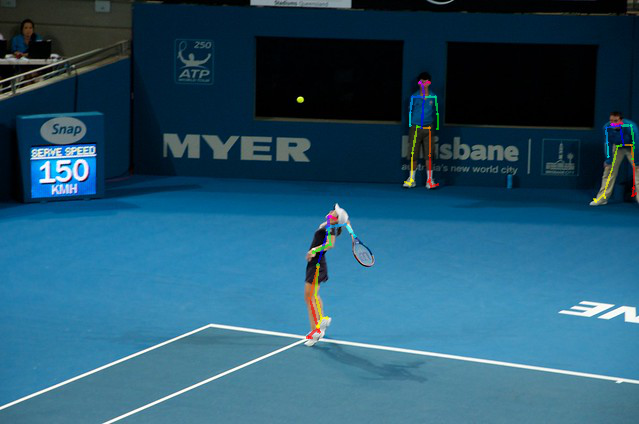

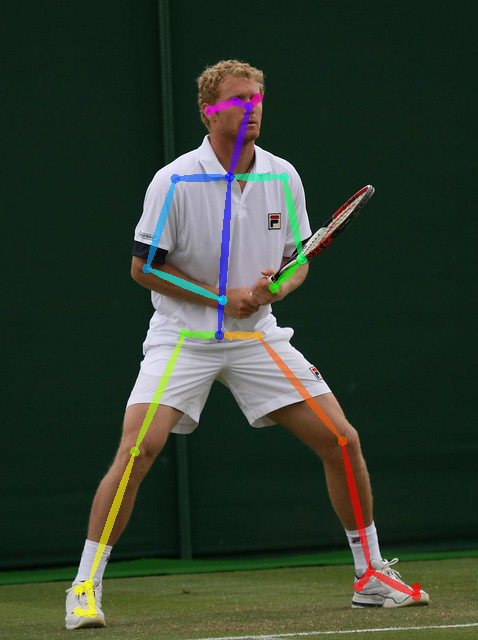

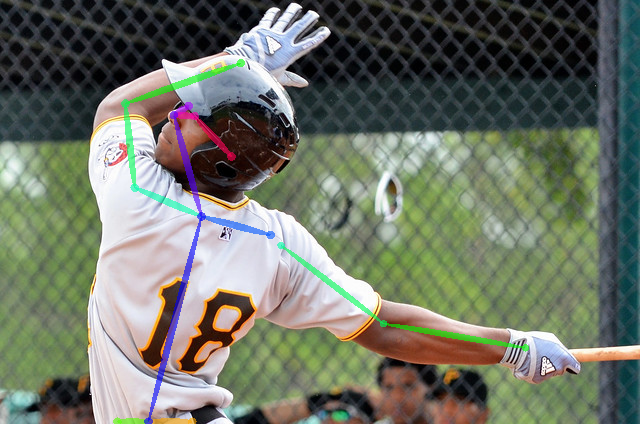

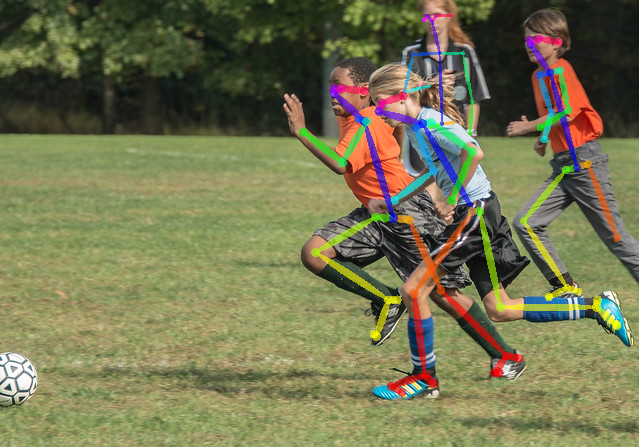

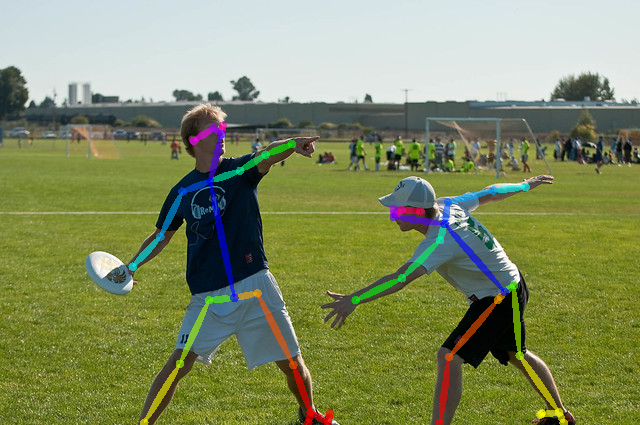

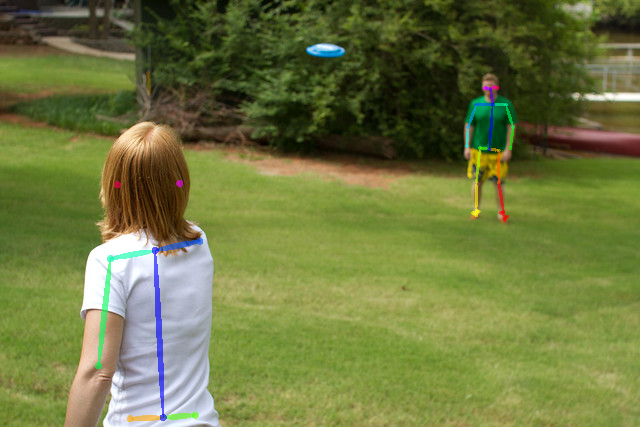

In [4]:

source = 'https://raw.githubusercontent.com/gabilodeau/INF6804/master/images'

IMG_NAMES = ['tennis1.jpg','tennis2.jpg', 'baseball.jpg','soccer.jpg','frisbee1.jpg','frisbee2.jpg']

for img_name in IMG_NAMES:
  imageToProcess = io.imread(os.path.join(source, img_name))
  datum.cvInputData = imageToProcess
  opWrapper.emplaceAndPop(op.VectorDatum([datum]))


  cv2_imshow((datum.cvOutputData)[...,::-1])
  print("\n")
  cv2.waitKey(0)

Load a sample video (here from the github of INF6804 course), get the poses predictions from the video frames.

In [5]:

source = 'https://raw.githubusercontent.com/gabilodeau/INF6804/master/videos'

examples = ['golf2.mp4', 'golf1.mp4']

for example in examples:
  # Video_Name = "https://raw.githubusercontent.com/sfnlm/DeepExamples/main/videos/golf2.mp4"
  cap = cv2.VideoCapture(os.path.join(source,example))
  frame_width = int(cap.get(3))
  frame_height = int(cap.get(4))
  fps= int(cap.get(5))

  # Define the file 'output_video.avi'
  output_name='{}.avi'.format(example.split('.')[0])
  out = cv2.VideoWriter(output_name,cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))

  # Extract poses
  while(cap.isOpened()):
    ret, imageToProcess = cap.read()
    if ret == True:
      datum.cvInputData = imageToProcess
      opWrapper.emplaceAndPop(op.VectorDatum([datum]))
      out.write(datum.cvOutputData)
    else:
      break
  cap.release()
  out.release()
  cv2.destroyAllWindows()


Here we visualize the predicted poses for each video sequence.

In [6]:
for example in examples:
  example_name = example.split('.')[0]
  os.system('ffmpeg -y -loglevel warning -i {}.avi {}.mp4'.format(example_name,example_name))
  mp4 = open('{}.mp4'.format(example_name),'rb').read()
  decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
  display(HTML(f'<video width=400 controls><source src={decoded_vid} type="video/mp4"></video>'))

**References:**

 - https://github.com/CMU-Perceptual-Computing-Lab/openpose

 - https://colab.research.google.com/github/tugstugi/dl-colab-notebooks/blob/master/notebooks/OpenPose.ipynb

 - [OpenPose: Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields paper](https://arxiv.org/abs/1812.08008)